In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache direc

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

tree is already the newest version (2.0.2-1).


In [ ]:
# 파이토치 관련 라이브러리

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [ ]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# 환경 설정 및 유틸리티 함수
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import urllib.request
import requests
from io import BytesIO

print(f'PyTorch: {torch.__version__}')
print(f'TorchVision: {torchvision.__version__}')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

# COCO 클래스 이름 정의 (80개)
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


PyTorch: 2.10.0+cu128
TorchVision: 0.25.0+cu128
Device: cuda


In [ ]:
def compute_iou(box1,box2): # box format (x1,y1,x2,y2)
  x1 = max(box1[0],box2[0])
  y1 = max(box1[1],box2[1])
  x2 = min(box1[2],box2[2])
  y2 = min(box1[3],box2[3])

  intersection = max(0,x2-x1) * max(0,y2-y1)
  area1 = (box1[2]-box1[0]) *(box1[3]-box1[1])
  area2 = (box2[2]-box2[0]) *(box2[3]-box2[1])
  union = area1 + area2  - intersection

  iou = intersection / union if union > 0 else 0
  return iou


In [ ]:
box_gt = [100,100,200,200]
box_pred1 = [120,120,220,220]
box_pred2 = [150,150,250,250]
box_pred3 = [250,250,350,350]

print(f"ground_truth : {box_gt}")
print(f'prediction_1 : {box_pred1}, iou :{compute_iou(box_gt,box_pred1):.3f}')
print(f'prediction_2 : {box_pred2}, iou :{compute_iou(box_gt,box_pred2):.3f}')
print(f'prediction_3 : {box_pred3}, iou :{compute_iou(box_gt,box_pred3):.3f}')

ground_truth : [100, 100, 200, 200]
prediction_1 : [120, 120, 220, 220], iou :0.471
prediction_2 : [150, 150, 250, 250], iou :0.143
prediction_3 : [250, 250, 350, 350], iou :0.000


In [ ]:
# NMS 함수 구현
"""
NMS : 중복되는 bbox 제거(겹치는 박스 중 가장 신뢰도 높은 score 높은 박스만 남기겠다 의지)
boxes : (N,4) [x1,y1,x2,y2]
score : (N,) - Confidence scores

"""

def simple_nms(boxes,scores,threshold=0.5):
  indicies = np.argsort(scores)[::-1]
  keep = []
  while len(indicies) > 0:
    current = indices[0]
    keep.append(current)
    for len(indices) == 1 :
      break

    current_box = boxes[current]
    remaining_boxes = boxes[indices[1:]]

    inous = np.array((compute_iou(current_box,box) for box in remaining_boxes))
    indices = indices[1:][ious <= threshold]

  return keep



In [ ]:
# NMS 테스트
test_boxes = np.array([
    [100, 100, 200, 200],
    [110, 110, 210, 210],
    [105, 105, 205, 205],
    [300, 300, 400, 400],
])

test_scores = np.array([0.9,0.8,0.85,0.95])
print(f"input_boxes : {len(test_boxes)}")
keep_indices = simple_nms(test_boxes,test_scores)
print(f"after nms, {len(keep_indices)} left")


input_boxes : 4
after nms, 2 left


Faster R-CNN모델

In [ ]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights).to(device)
model.eval()
preprocess = weights.transforms()


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 179MB/s]


In [ ]:
# 테스트 이미지 준비
def create_sample_image():
    """샘플 이미지 생성 (사람, 의자, 책 그리기)"""
    img = Image.new('RGB', (800, 600), color=(240, 240, 240))
    draw = ImageDraw.Draw(img)

    # 사람 그리기 (간단한 스틱맨)
    # 머리
    draw.ellipse([150, 100, 250, 200], fill=(255, 220, 180), outline=(0, 0, 0), width=3)
    # ellipse:  원형 outline=(0, 0, 0) 윤곽선 검정색
    # 몸통
    draw.rectangle([180, 200, 220, 400], fill=(0, 100, 200), outline=(0, 0, 0), width=3)
    # 팔
    draw.line([180, 250, 120, 300], fill=(0, 100, 200), width=15)
    draw.line([220, 250, 280, 300], fill=(0, 100, 200), width=15)
    # 다리
    draw.line([180, 400, 140, 550], fill=(50, 50, 50), width=15)
    draw.line([220, 400, 260, 550], fill=(50, 50, 50), width=15)

    # 의자 그리기
    draw.rectangle([500, 300, 650, 350], fill=(139, 69, 19), outline=(0, 0, 0), width=3)
    draw.rectangle([520, 350, 540, 500], fill=(139, 69, 19), outline=(0, 0, 0), width=3)
    draw.rectangle([610, 350, 630, 500], fill=(139, 69, 19), outline=(0, 0, 0), width=3)
    draw.rectangle([510, 150, 640, 300], fill=(160, 82, 45), outline=(0, 0, 0), width=3)

    # 책 그리기
    draw.rectangle([350, 450, 450, 550], fill=(200, 50, 50), outline=(0, 0, 0), width=3)
    draw.line([400, 450, 400, 550], fill=(0, 0, 0), width=2)

    # 텍스트 추가
    draw.text((300, 30), "Sample Detection Image", fill=(0, 0, 0))

    return img

다운로드 시도: https://raw.githubusercontent.com/ultralytics/yolo...
이미지 다운로드 성공!
이미지 리사이즈: (1000, 563)


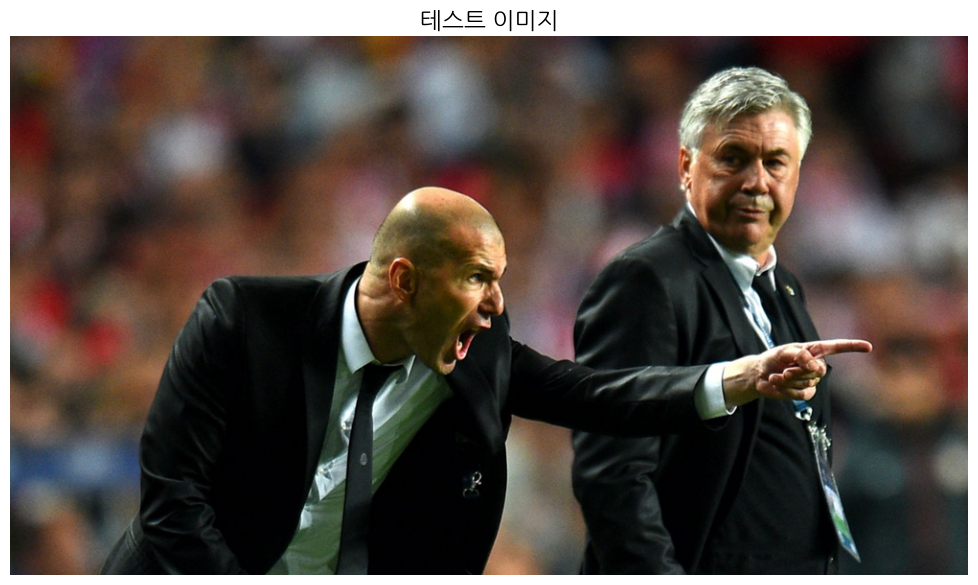

이미지 크기: (1000, 563)


In [ ]:
def download_image_safe():

    urls = [
        "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/zidane.jpg",
        "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg",
        "https://ultralytics.com/images/zidane.jpg",
    ]

    for url in urls:
        try:
            print(f"다운로드 시도: {url[:50]}...")
            response = requests.get(url, timeout=5, headers={'User-Agent': 'Mozilla/5.0'})
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert("RGB")
                print(f"이미지 다운로드 성공!")
                return img
        except Exception as e:
            print(f"  실패: {str(e)[:50]}")
            continue

    return None

img = download_image_safe()

if img is None:
    # 온라인 다운로드 실패 → 샘플 이미지 생성
    img = create_sample_image()

else:
    # 이미지가 너무 크면 리사이즈
    if max(img.size) > 1000:
        img.thumbnail((1000, 1000))
        print(f"이미지 리사이즈: {img.size}")

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('테스트 이미지')
plt.tight_layout()
plt.show()

print(f"이미지 크기: {img.size}")

In [ ]:
img_tensor = preprocess(img).unsqueeze(0).to(device)


with torch.no_grad():
  prediction = model(img_tensor)[0]
prediction.keys()

boxes = prediction['boxes'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()

print(f'검출된 객체수 : {len(boxes)}')

if len(scores) > 0:
  print(f'confidence 범위 : {scores.min():.2f} - {scores.max():.2f}')
else :
  print("검출된 객체 없어요")

검출된 객체수 : 39
confidence 범위 : 0.05 - 0.99


필터링 한 후 객체 수 : 9
1,person(confidence : 0.99), Box : (89,136,866,557)
2,person(confidence : 0.99), Box : (527,36,898,538)
3,tie(confidence : 0.98), Box : (334,338,405,550)
4,tie(confidence : 0.92), Box : (764,247,799,327)
5,tie(confidence : 0.87), Box : (774,242,808,316)
6,tie(confidence : 0.85), Box : (780,240,833,322)
7,tie(confidence : 0.67), Box : (342,332,503,547)
8,person(confidence : 0.60), Box : (850,237,998,555)
9,person(confidence : 0.57), Box : (590,29,856,351)


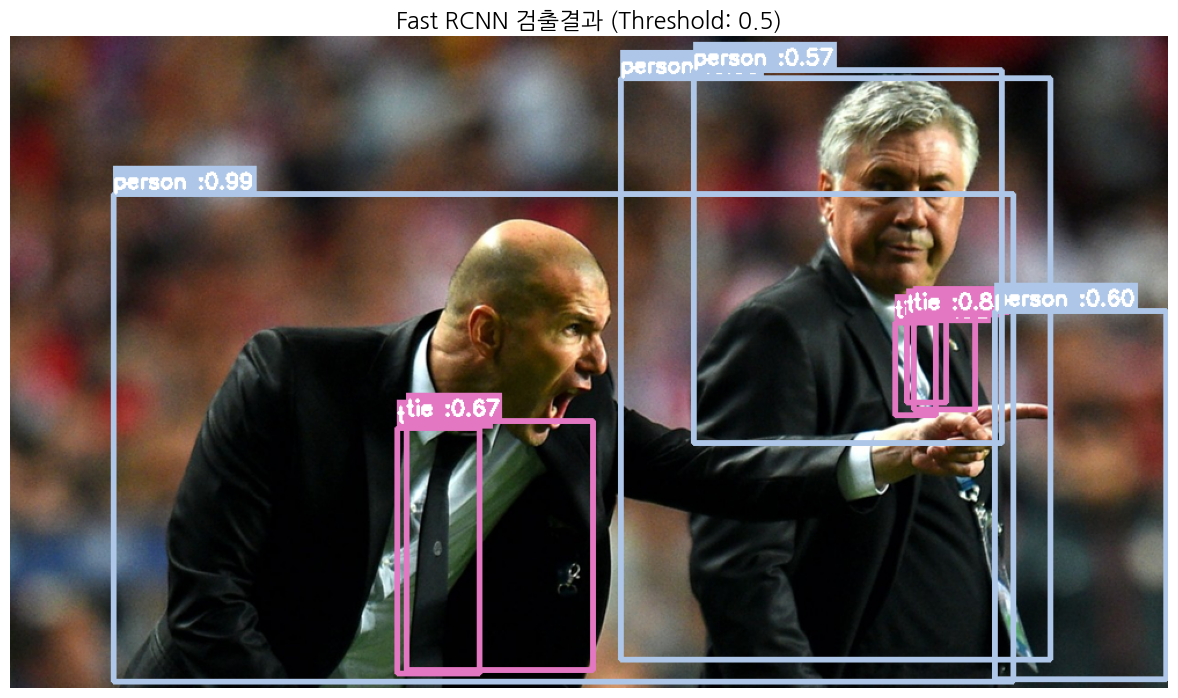

In [ ]:
thr = 0.5

# we need to remove object having less confidence
if len(boxes) > 0 :
  mask = scores > thr
  filtered_boxes = boxes[mask]
  filtered_scores = scores[mask]
  filtered_labels = labels[mask]

  print(f"filtered object:{len(filterd_boxes)}")

  if len(filtered_boxes) > 0 :
    img_np = np.array(img)
    img_draw = img_np.copy()

    #define color
    colors =plt.cm.tab20(np.linspace(0,1,20))

    for i, (box,score,label) in enumerate(zip(filtered_boxes, filtered_scores,filtered_labels)):
      x1,y1,x2,y2 = box.astype(int)
      class_name = COCO_CLASSES[label]
      # we already defined 20 colors that is also divided 20 steps based on saturation
      # so we use differnt color with 20 labels and only take R,G,B without alpha, and convert it to int because it might be float
      color = tuple((np.array(colors[label % 20][:3])*255).astype(int).tolist())
      # draw box
      cv2.rectangle(img_draw,(x1,y1),(x2,y2),color,3)
      # draw label
      text = f'{class_name}:{score:.2f}'
      (text_w,text_h),_ = cv2.getTextSize(text,cv2.FONT_HERSHEY_SIMPLEX,0.6,2)
      cv2.rectangle(img_draw,(x1,y1 - text_h - 10),(x1 + text_w,y1),color,-1)
      cv2.putText(img_draw,text,(x1,y1-5),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255),2)
      print(f'{i+1},{class_name}(confidence:{score:.2f}),Box :[{x1},{y1},{x2},{y2}]')

    plt.figure(figsize=(12,8))
    plt.imshow(img_draw)
    plt.axis('off')
    plt.title(f'Fast RCNN thr(Threshold:{thr})')
    plt.tight_layout()
    plt.show()
  else:
    print(f'there is no obejct over Threshold {thr}')
else:
  print(f'there is any object detected')


Threshold 0.3: 12개 검출
Threshold 0.5: 9개 검출
Threshold 0.7: 6개 검출
Threshold 0.9: 4개 검출


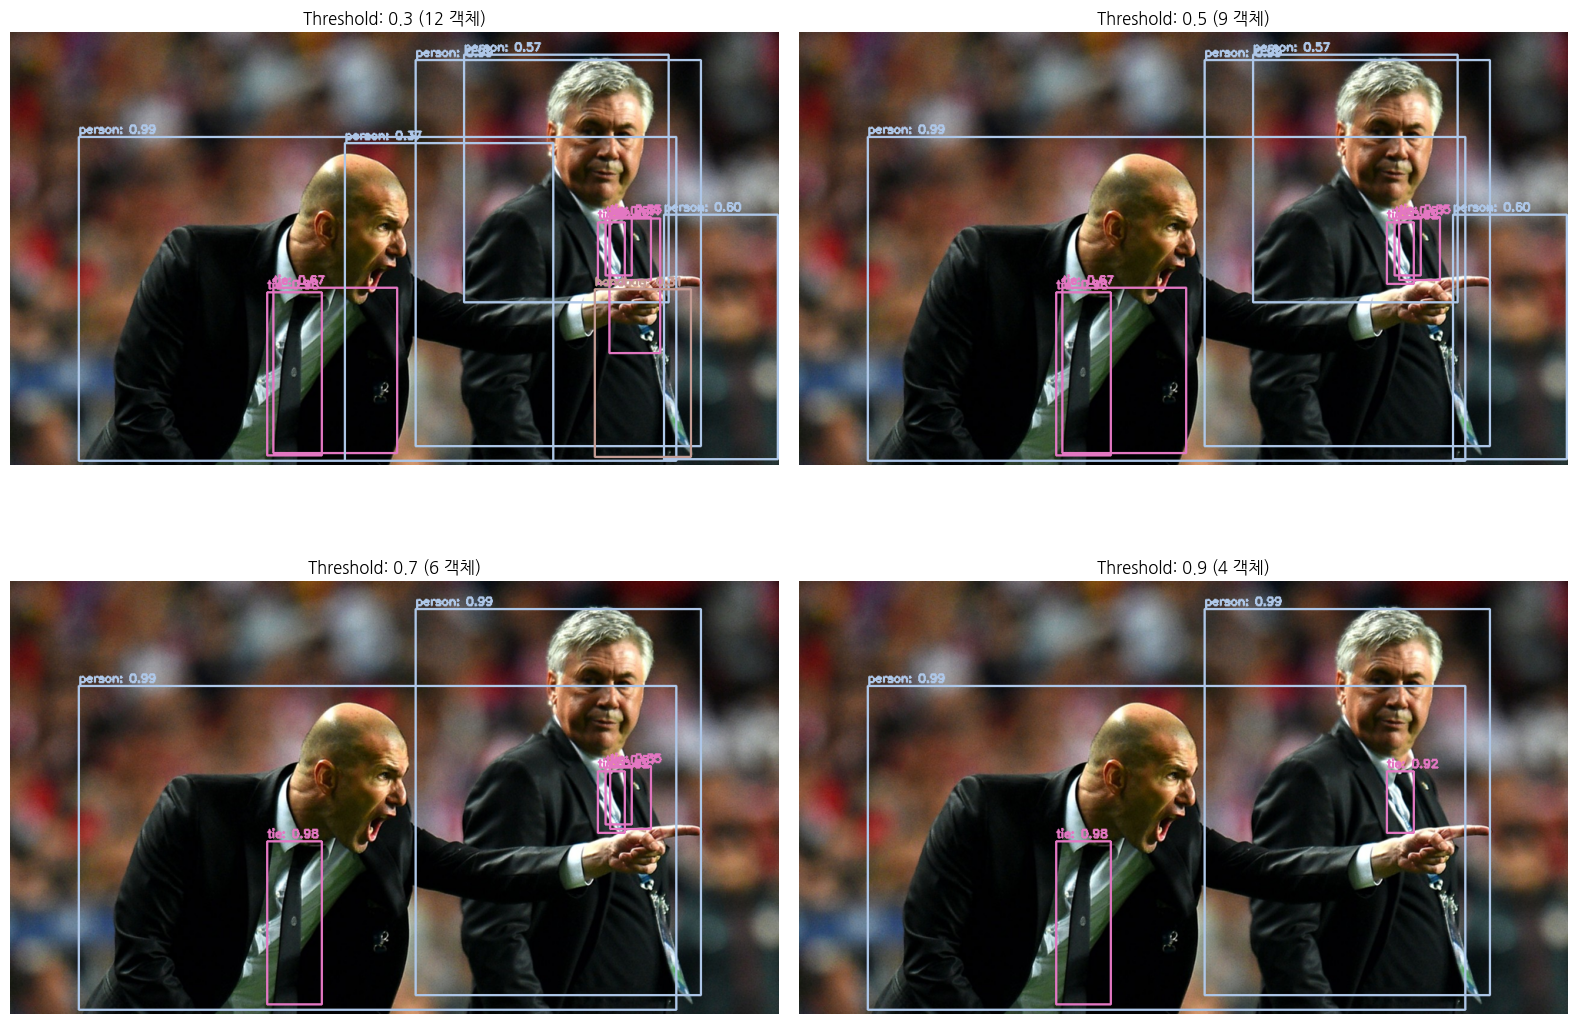

In [ ]:
# 다양한 Threshold 비교
if len(boxes) > 0:
    thresholds = [0.3, 0.5, 0.7, 0.9]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    img_np = np.array(img)
    colors = plt.cm.tab20(np.linspace(0, 1, 20))

    for idx, thresh in enumerate(thresholds):
        mask = (scores >= thresh)
        img_temp = img_np.copy()

        temp_boxes = boxes[mask]
        temp_scores = scores[mask]
        temp_labels = labels[mask]

        for box, score, label in zip(temp_boxes, temp_scores, temp_labels):
            x1, y1, x2, y2 = box.astype(int)
            class_name = COCO_CLASSES[label]
            color = tuple((np.array(colors[label % 20][:3]) * 255).astype(int).tolist())

            cv2.rectangle(img_temp, (x1, y1), (x2, y2), color, 2)
            text = f'{class_name}: {score:.2f}'
            cv2.putText(img_temp, text, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        axes[idx].imshow(img_temp)
        axes[idx].axis('off')
        axes[idx].set_title(f'Threshold: {thresh} ({len(temp_boxes)} 객체)', fontsize=12)
        print(f"Threshold {thresh}: {len(temp_boxes)}개 검출")

    plt.tight_layout()
    plt.show()


클래스별 검출 수 (Threshold >=0.5):
tie: 5개 (평균 confidence: 0.858)
person: 4개 (평균 confidence: 0.788)


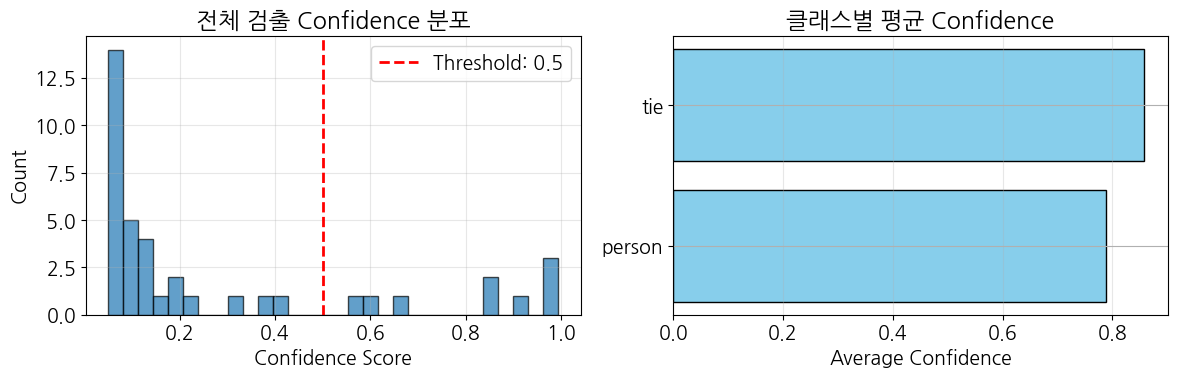

In [ ]:
# 검출 통계 분석
if len(boxes) > 0 and len(boxes[scores >= conf_threshold]) > 0:

    # 코드 작성
    # 기준점(임계치) threshold 이상을 충족(True)하는 박스만 선택
    # >> class label과 score 만 선택해줘
    mask = (scores >= conf_threshold) # T/F 출력
    filtered_labels = labels[mask]
    filtered_scores = scores[mask]

    # 클래스 별 통계
    from collections import Counter
    class_counts = Counter(filtered_labels)

    print(f"\n클래스별 검출 수 (Threshold >={conf_threshold}):")

    for label_id, count in class_counts.most_common():
        class_name = COCO_CLASSES[label_id]
        avg_conf = filtered_scores[filtered_labels == label_id].mean()
        print(f"{class_name}: {count}개 (평균 confidence: {avg_conf:.3f})")

    # Confidence 분포 시각화
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(scores, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(x=conf_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold: {conf_threshold}')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.title('전체 검출 Confidence 분포')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    class_names = [COCO_CLASSES[l] for l in filtered_labels]
    unique_classes = list(set(class_names))
    class_scores = [filtered_scores[np.array(class_names) == c].mean()
                    for c in unique_classes]
    plt.barh(unique_classes, class_scores, color='skyblue', edgecolor='black')
    plt.xlabel('Average Confidence')
    plt.title('클래스별 평균 Confidence')
    plt.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()